In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [2]:
train_set='/kaggle/input/wlidata/save/train'
val_set='/kaggle/input/wlidata/save/val'
test_set='/kaggle/input/wlidata/save/test'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')

Found 4535 images belonging to 8 classes.
Found 1294 images belonging to 8 classes.
Found 661 images belonging to 8 classes.


In [5]:
train_generator.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [6]:
pip install keras-cv


Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0  # Placeholder since no ViT in applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load Vision Transformer (ViT) using EfficientNetV2B0 as a placeholder
# (Replace with ViT when TF officially supports it)
base_model_vit = EfficientNetV2B0(weights='imagenet', input_shape=(224,224,3), include_top=False)

# Freeze the layers in the base model
for layer in base_model_vit.layers:
    layer.trainable = False

# Create the model
model_vit = Sequential()
model_vit.add(base_model_vit)
model_vit.add(GaussianNoise(0.35))
model_vit.add(GlobalAveragePooling2D())
model_vit.add(Dense(256, activation='relu'))
model_vit.add(BatchNormalization())
model_vit.add(GaussianNoise(0.35))
model_vit.add(Dropout(0.2))
model_vit.add(Dense(8, activation='softmax'))  # Modify output classes as needed

# Print model summary
model_vit.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,250,328 (23.84 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

In [8]:
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
checkpoint = ModelCheckpoint('bestx_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [11]:
history = model_vit.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 161s 465ms/step - AUC: 0.7915 - Precision: 0.4823 - Recall: 0.2874 - accuracy: 0.4058 - loss: 1.7429 - val_AUC: 0.9705 - val_Precision: 0.7971 - val_Recall: 0.6445 - val_accuracy: 0.7406 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 2/300
  1/283 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 0.9565 - Precision: 0.9091 - Recall: 0.6250 - accuracy: 0.6875 - loss: 0.7686

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - AUC: 0.9565 - Precision: 0.9091 - Recall: 0.6250 - accuracy: 0.6875 - loss: 0.7686 - val_AUC: 0.8695 - val_Precision: 0.3750 - val_Recall: 0.2143 - val_accuracy: 0.3571 - val_loss: 1.3541 - learning_rate: 1.0000e-04
Epoch 3/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 88s 306ms/step - AUC: 0.9542 - Precision: 0.7462 - Recall: 0.6380 - accuracy: 0.6940 - loss: 0.7953 - val_AUC: 0.9765 - val_Precision: 0.8162 - val_Recall: 0.7422 - val_accuracy: 0.7867 - val_loss: 0.5514 - learning_rate: 1.0000e-04
Epoch 4/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - AUC: 0.9208 - Precision: 0.6429 - Recall: 0.5625 - accuracy: 0.6875 - loss: 1.0963 - val_AUC: 0.9712 - val_Precision: 0.7857 - val_Recall: 0.7857 - val_accuracy: 0.7857 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 5/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 88s 304ms/step - AUC: 0.9673 - Precision: 0.7883 - Recall: 0.7021 - accuracy: 0.7453 - loss: 0.6634 - val_AUC: 0.9820 - val_Precision: 0.8319 - val_Reca

In [12]:
train_evaluation = model_vit.evaluate(train_generator)

284/284 ━━━━━━━━━━━━━━━━━━━━ 72s 254ms/step - AUC: 0.9975 - Precision: 0.9323 - Recall: 0.9236 - accuracy: 0.9287 - loss: 0.1816


In [13]:
validation_evaluation = model_vit.evaluate(validation_generator)

81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - AUC: 0.9903 - Precision: 0.8776 - Recall: 0.8582 - accuracy: 0.8638 - loss: 0.3422


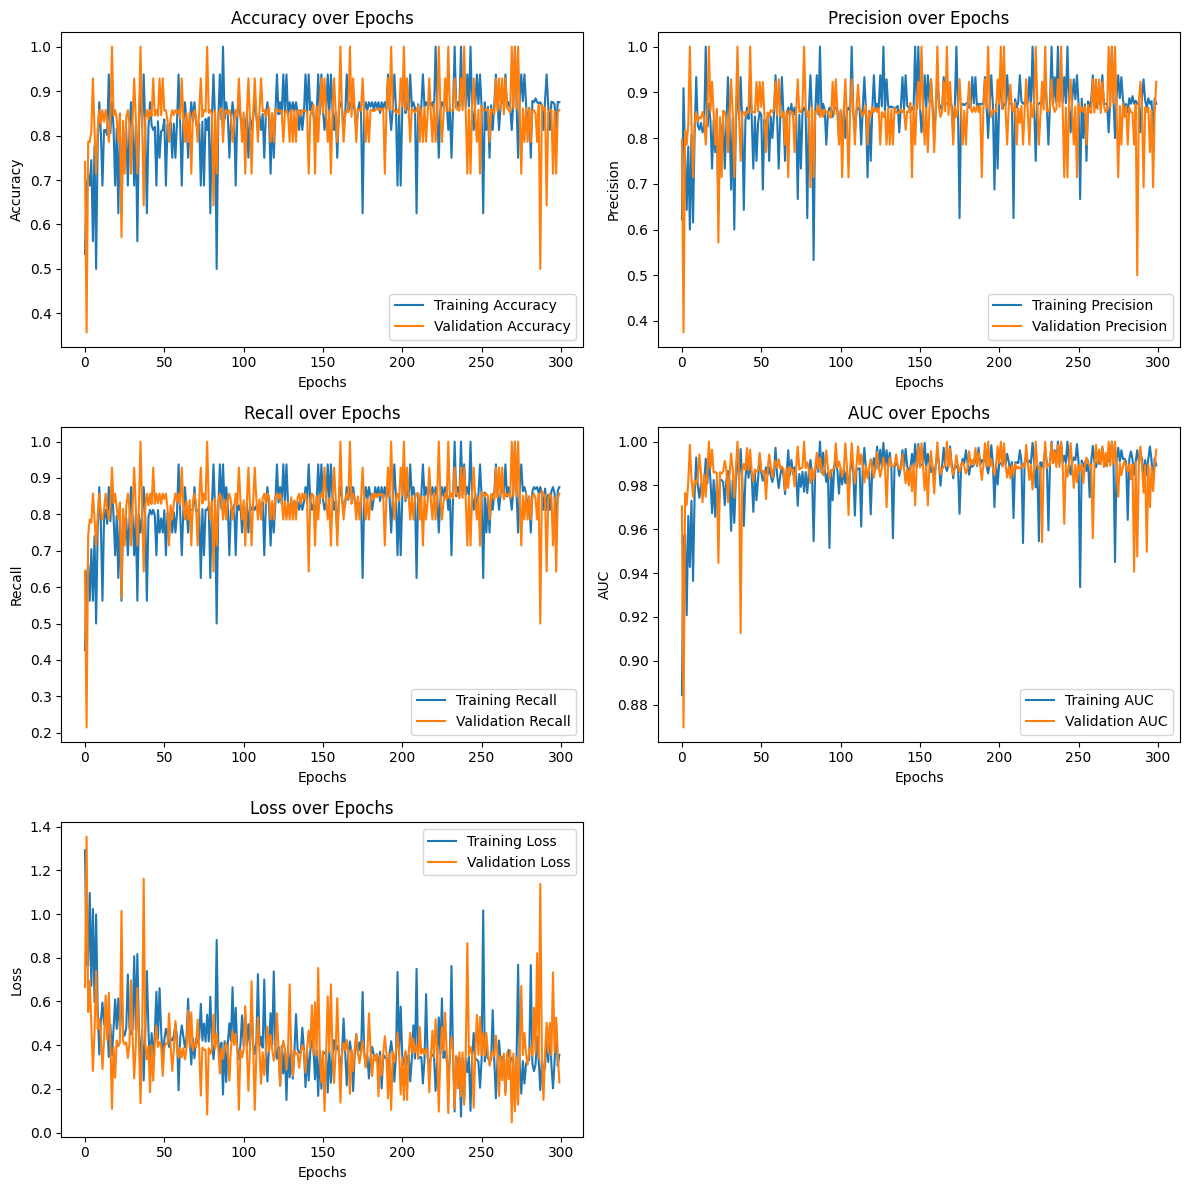

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(history.history['Precision'], label='Training Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(3, 2, 4)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Loss plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'lr' in history.history:
    plt.subplot(3, 2, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

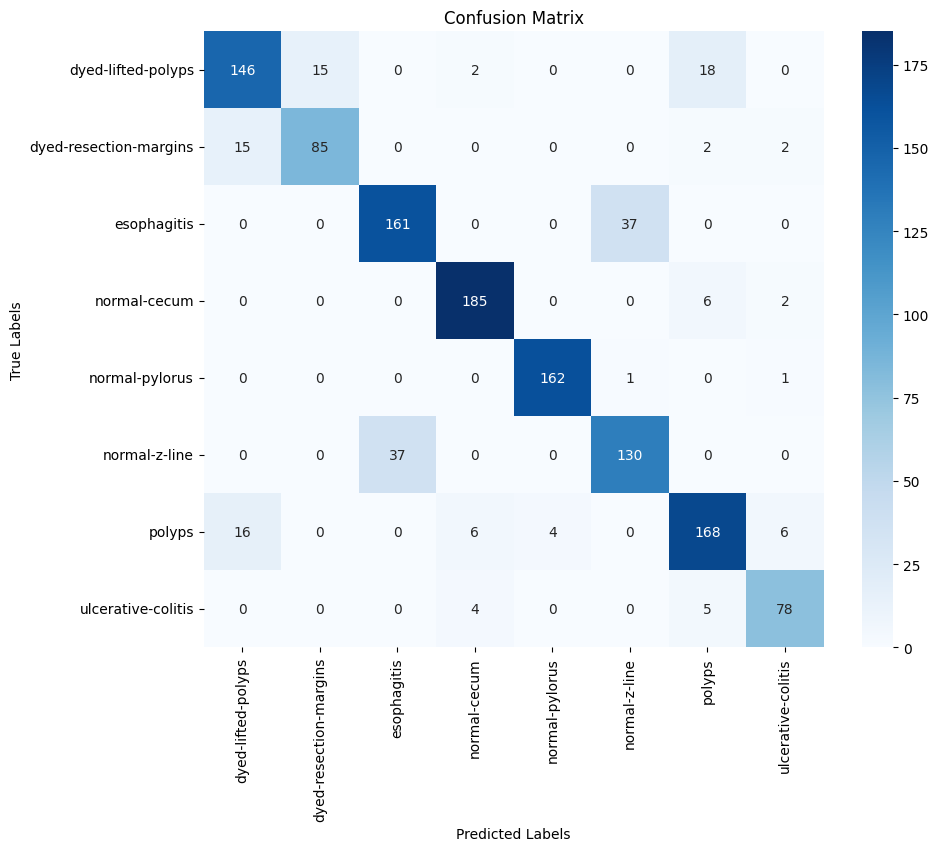

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.82      0.81      0.82       181
dyed-resection-margins       0.85      0.82      0.83       104
           esophagitis       0.81      0.81      0.81       198
          normal-cecum       0.94      0.96      0.95       193
        normal-pylorus       0.98      0.99      0.98       164
         normal-z-line       0.77      0.78      0.78       167
                polyps       0.84      0.84      0.84       200
    ulcerative-colitis       0.88      0.90      0.89        87

              accuracy                           0.86      1294
             macro avg       0.86      0.86      0.86      1294
          weighted avg       0.86      0.86      0.86      1294



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_generator.reset()


true_labels = []
predicted_probs = []


for i in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model_vit.predict(imgs), axis=1))


cm = confusion_matrix(true_labels, predicted_probs)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predicted_probs, target_names=list(validation_generator.class_indices.keys()))) 